<a href="https://colab.research.google.com/github/swap-mitra/deep-learning/blob/main/Potato_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [34]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np


from google.colab import drive
drive.mount('/content/drive')


%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Getting the Data

In [2]:
# Constants
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potato-disease",
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Data Exploration

In [5]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 1 0 0 1 0 0 1 1 1 2 1 0 0 1 0 1 1 1 1 1 0 0 2 1 1 1 1]


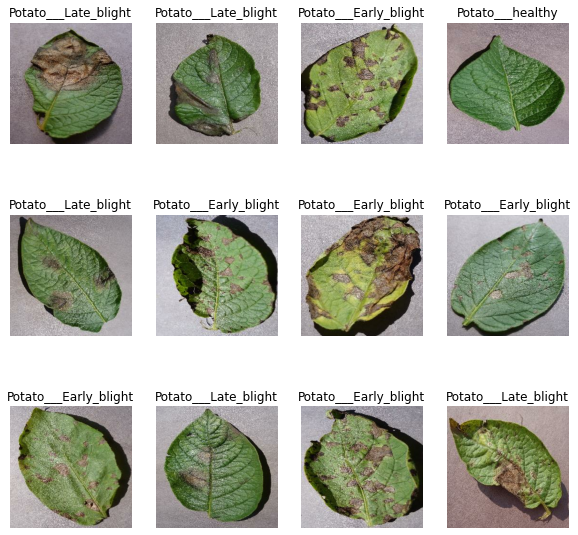

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## Train Test Split

In [7]:
def get_dataset_partitions_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  
  return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Scaling 

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation

In [11]:
data_augmentaion = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

##Building and Running Model

In [12]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
        resize_and_rescale,
        data_augmentaion,
        layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 239s 221ms/step - loss: 0.8554 - accuracy: 0.5185 - val_loss: 0.6833 - val_accuracy: 0.7292
Epoch 2/50
54/54 [==============================] - 6s 120ms/step - loss: 0.5789 - accuracy: 0.7419 - val_loss: 0.5079 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 6s 118ms/step - loss: 0.3764 - accuracy: 0.8351 - val_loss: 0.2840 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 7s 120ms/step - loss: 0.2792 - accuracy: 0.8889 - val_loss: 0.2366 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2452 - accuracy: 0.9086 - val_loss: 0.2189 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 6s 119ms/step - loss: 0.2101 - accuracy: 0.9167 - val_loss: 0.1258 - val_accuracy: 0.9531
Epoch 7/50
54/54 [==============================] - 6s 119ms/step - loss: 0.1774 - accuracy: 0.9375 - val_loss: 0.1874 - val_accuracy: 0.9062
Epoc

In [16]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 48ms/step - loss: 0.0155 - accuracy: 0.9922


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

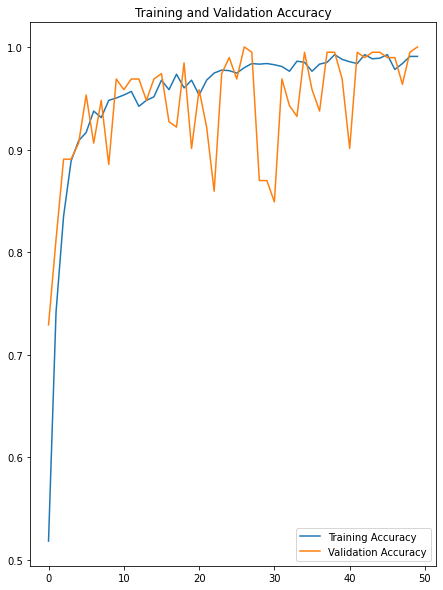

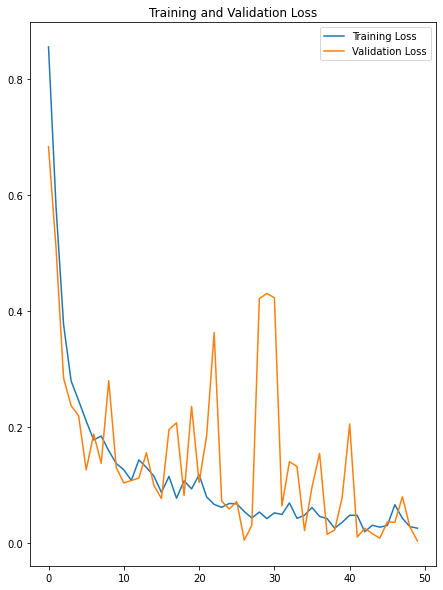

In [30]:
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.figure(figsize=(16,10))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

## Predictions

Actual Label : Potato___Early_blight
Predicted Label : Potato___Early_blight


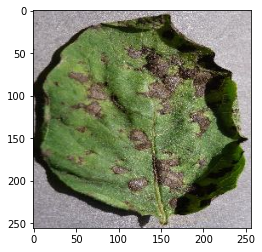

In [38]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  plt.imshow(first_image)
  print("Actual Label :", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted Label :", class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
  img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_arr = tf.expand_dims(img_arr, 0)

  predictions = model.predict(img_arr)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

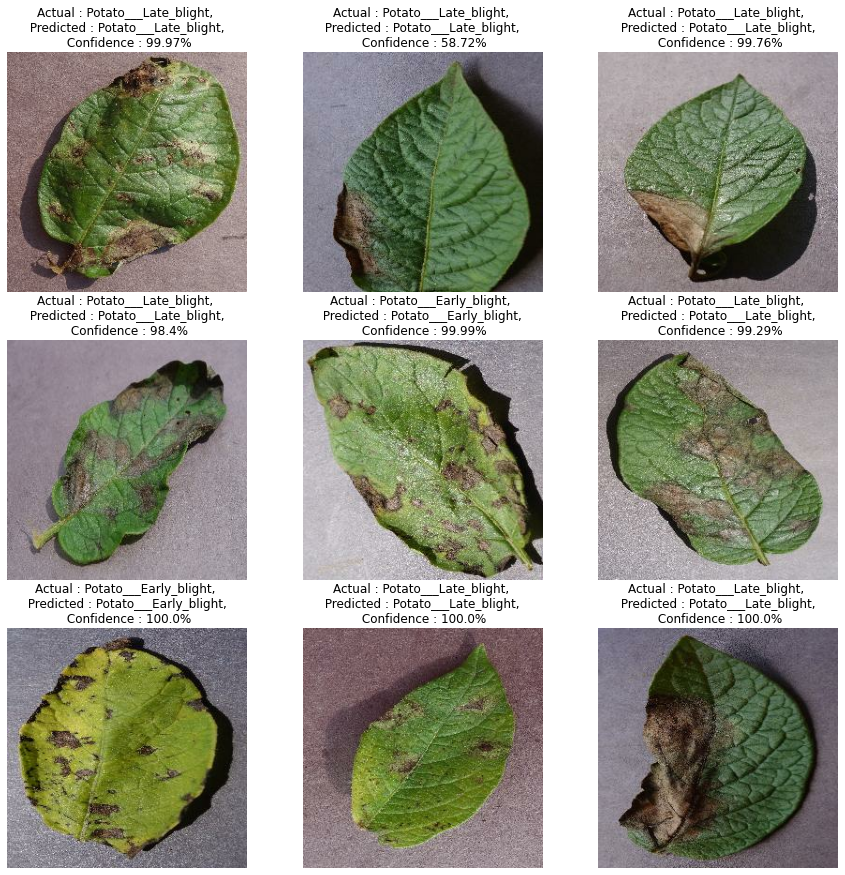

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence : {confidence}%")

## Saving Model

In [49]:
model_version = 1
model.save(f"/content/drive/MyDrive/potato-disease/model/{model_version}")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/potato-disease/model/1/assets
